# Training a binary image classifier for deepfakes

This notebook trains an Efficientnet B7 on a deepfake face crop dataset.

Note: This notebook requires wandb to be installed in your environment and for you to be logged in. If you do not wish to use wandb, please set the `tracking_active` variable to `False`.

In [1]:
tracking_active = True

In [56]:
if tracking_active:
    import wandb
    wandb.init(
        name='efficientnet-b7-deeptrain-full-dataset',
        notes='Samples all face crops and train on full dataset',
        project="deepfake-detection"
    )

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/ishaan-malhi/deepfake-detection/runs/n13k2pt5

In [2]:
import os, sys, random
import numpy as np
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda')

In [8]:
torch.cuda.current_device()

0

In [6]:
torch.cuda.device_count()

2

In [93]:
image_size = 224
batch_size = 128

## The data

We use [this dataset](https://www.kaggle.com/dagnelies/deepfake-faces) to transfer learn an Imagenet model into a binary classifier to detect deepfakes.

In [94]:
crops_dir = "./data/faces_224"

metadata_df = pd.read_csv("./data/metadata.csv")
metadata_df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [95]:
len(metadata_df)

95634

How many faces of each class do we have?

In [96]:
len(metadata_df[metadata_df.label == "REAL"]), len(metadata_df[metadata_df.label == "FAKE"])

(16293, 79341)

Look at a random face image:

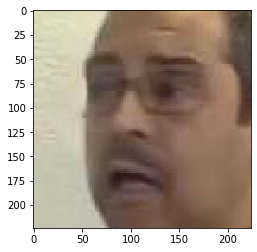

In [97]:
img_path = os.path.join(crops_dir, np.random.choice(os.listdir(crops_dir)))
plt.imshow(cv2.imread(img_path)[..., ::-1])

## The dataset and data loaders

Note: This section has code adapted from [this Kaggle Kernel](#Binary-Classification-Demo)

"Like most other torchvision models, the model we're using requires that input images are normalized using mean and stddev. For making plots, we also define an "unnormalize" transform that can take a normalized image and turn it back into regular pixels."

In [98]:
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

During training, we'll apply data augmentation. We try random horizontal flips. In other kernels, we try more data augmentation techniques. But in this notebook, we are interested in finding out the performance of Efficientnet.

In [99]:
def random_hflip(img, p=0.5):
    """Random horizontal flip."""
    if random.random() < p:
        return cv2.flip(img, 1)
    else:
        return img

Some helper code for loading a training image and its label:

In [100]:
def load_image_and_label(filename, cls, crops_dir, image_size, augment):
    """Loads an image into a tensor. Also returns its label."""
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if augment: 
        img = random_hflip(img)

    img = cv2.resize(img, (image_size, image_size))

    img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
    img = normalize_transform(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

Testing.

The following cell should return a normalized PyTorch tensor of shape (3, 224, 224) and the target 1 (for fake).

Note that this dataset has 155x155 images but our model needs at least 224x224, so we resize them.

In [101]:
img, target = load_image_and_label("aabuyfvwrh.jpg", "FAKE", crops_dir, 224, augment=True)
img.shape, target

(torch.Size([3, 224, 224]), 1)

To plot the image, we need to unnormalize it and also permute it from (3, 224, 224) to (224, 224, 3). 

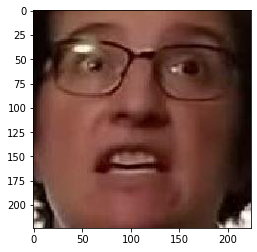

In [102]:
plt.imshow(unnormalize_transform(img).permute((1, 2, 0)))

To use the PyTorch data loader, we need to create a `Dataset` object.

From [1](#Binary-Classification-Demo) - "Because of the class imbalance (many more fakes than real videos), we're using a dataset that samples a given number of REAL faces and the same number of FAKE faces, so it's always 50-50."

Note: Class imbalance has varying performance over different networks. We later train this Efficientnet on the entire face crop dataset, disregarding class imbalance.

In [103]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    """Face crops dataset.

    Arguments:
        crops_dir: base folder for face crops
        df: Pandas DataFrame with metadata
        split: if "train", applies data augmentation
        image_size: resizes the image to a square of this size
        sample_size: evenly samples this many videos from the REAL
            and FAKE subfolders (None = use all videos)
        seed: optional random seed for sampling
    """
    def __init__(self, crops_dir, df, split, image_size, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        
        if sample_size is not None:
            real_df = df[df["label"] == "REAL"]
            fake_df = df[df["label"] == "FAKE"]
            sample_size = np.min(np.array([sample_size, len(real_df), len(fake_df)]))
            print("%s: sampling %d from %d real videos" % (split, sample_size, len(real_df)))
            print("%s: sampling %d from %d fake videos" % (split, sample_size, len(fake_df)))
            real_df = real_df.sample(sample_size, random_state=seed)
            fake_df = fake_df.sample(sample_size, random_state=seed)
            self.df = pd.concat([real_df, fake_df])
        else:
            self.df = df

        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["videoname"][:-4] + ".jpg"
        cls = row["label"]
        return load_image_and_label(filename, cls, self.crops_dir, 
                                    self.image_size, self.split == "train")
    def __len__(self):
        return len(self.df)

Let's test that the dataset actually works...

In [104]:
dataset = VideoDataset(crops_dir, metadata_df, "val", image_size, seed=1234)

val dataset has 16293 real videos, 79341 fake videos


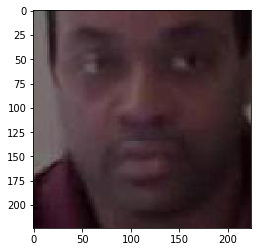

In [105]:
plt.imshow(unnormalize_transform(dataset[0][0]).permute(1, 2, 0))

In [106]:
del dataset

From [1](#Binary-Classification-Demo) - Split up the data into train / validation. There are many different ways to do this. For this kernel, we're going to just grab a percentage of the REAL faces as well as their corresponding FAKEs. This way, a real video and all the fakes that are derived from it will be either completely in the training set or completely in the validation set. 

(This is still not ideal because the same person may appear in many different videos. Ideally we want a person to be either in train or in val, but not in both. But it will do for now.)

In [107]:
def make_splits(crops_dir, metadata_df, frac):
    # Make a validation split. Sample a percentage of the real videos, 
    # and also grab the corresponding fake videos.
    real_rows = metadata_df[metadata_df["label"] == "REAL"]
    real_df = real_rows.sample(frac=frac, random_state=666)
    fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
    val_df = pd.concat([real_df, fake_df])

    # The training split is the remaining videos.
    train_df = metadata_df.loc[~metadata_df.index.isin(val_df.index)]

    return train_df, val_df

Sanity check:

In [108]:
train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

assert(len(train_df) + len(val_df) == len(metadata_df))
assert(len(train_df[train_df["videoname"].isin(val_df["videoname"])]) == 0)

del train_df, val_df

Use all of the above building blocks to create `DataLoader` objects. Note that we use only a portion of the full amount of training data, for speed reasons. If you have more patience, increase the `sample_size`.

In [109]:
from torch.utils.data import DataLoader

def create_data_loaders(crops_dir, metadata_df, image_size, batch_size, num_workers):
    train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

    train_dataset = VideoDataset(crops_dir, train_df, "train", image_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)

    val_dataset = VideoDataset(crops_dir, val_df, "val", image_size, seed=1234)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [110]:
train_loader, val_loader = create_data_loaders(crops_dir, metadata_df, image_size, 
                                               batch_size, num_workers=2)

train dataset has 15478 real videos, 75449 fake videos
val dataset has 815 real videos, 3892 fake videos


And, as usual, a check that it works... The `train_loader` should give a different set of examples each time you run it (because `shuffle=True`), while the `val_loader` always returns the examples in the same order.

tensor(1)


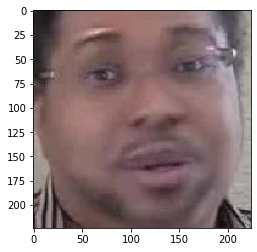

In [111]:
X, y = next(iter(train_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

tensor(0)


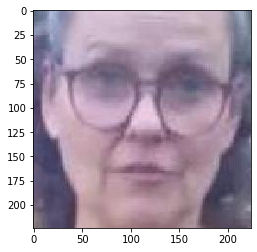

In [112]:
X, y = next(iter(val_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

## Helper code for training

Evaluation function for running the model on the validation set:

In [113]:
def evaluate(net, data_loader, device, silent=False):
    net.train(False)

    bce_loss = 0
    total_examples = 0

    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()

                y_pred = net(x)
                y_pred = y_pred.squeeze()

                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size

            total_examples += batch_size
            pbar.update()

    bce_loss /= total_examples

    if silent:
        return bce_loss
    else:
        print("BCE: %.4f" % (bce_loss))

## Training Loop

In [114]:
def fit(epochs):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(train_loader), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            
            bce_loss = 0
            total_examples = 0

            net.train(True)

            for batch_idx, data in enumerate(train_loader):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                
                optimizer.zero_grad()

                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)

                total_examples += batch_size
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1

            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

            val_bce_loss = evaluate(net, val_loader, device=gpu, silent=True)
            history["val_bce"].append(val_bce_loss)
            
            if tracking_active:
                wandb.log({"bce_loss": bce_loss, "epoc": epoch, "val_bce": val_bce_loss})
            
            print("val BCE: %.4f" % (val_bce_loss))

            ## anneal the learning rate
            lr = lr/10
            set_lr(optimizer, lr)

            print("")

## The model

In this section we define our base model and transfer learn the model to the deepfake face crop dataset.

In [115]:
import torchvision

Enable any of the following models and set them as the base model. In this notebook, we use Efficientnet b7, and it's implmentation in Pytorch from [here](https://github.com/lukemelas/EfficientNet-PyTorch#loading-pretrained-models).

In [36]:
# resnext50 = torchvision.models.resnext50_32x4d(pretrained=True)

In [37]:
# ressnext101 = torchvision.models.resnext101_32x8d(pretrained=True)

In [38]:
#wideresnext101 = torchvision.models.wide_resnet101_2(pretrained=True)

In [135]:
## Pull in efficient net
#https://github.com/lukemelas/EfficientNet-PyTorch
# !pip install -q --upgrade efficientnet-pytorch
## TODO: Clean this up so we can specify model and get pretrained model as `net`
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7') 

Loaded pretrained weights for efficientnet-b7


In [136]:
model_dict = {
#     'resnext50': resnext50,
#     'resnext101': ressnext101
}

In [137]:
checkpoint = model

In [138]:
def list_layers(net):
    return [k for k,v in net.named_parameters() if v.requires_grad]

Let's see the layers of the model we have picked. We can then define which layers we want to freeze to prevent gradient update for transfer learning.

In [139]:
list_layers(checkpoint)

['_conv_stem.weight',
 '_bn0.weight',
 '_bn0.bias',
 '_blocks.0._depthwise_conv.weight',
 '_blocks.0._bn1.weight',
 '_blocks.0._bn1.bias',
 '_blocks.0._se_reduce.weight',
 '_blocks.0._se_reduce.bias',
 '_blocks.0._se_expand.weight',
 '_blocks.0._se_expand.bias',
 '_blocks.0._project_conv.weight',
 '_blocks.0._bn2.weight',
 '_blocks.0._bn2.bias',
 '_blocks.1._depthwise_conv.weight',
 '_blocks.1._bn1.weight',
 '_blocks.1._bn1.bias',
 '_blocks.1._se_reduce.weight',
 '_blocks.1._se_reduce.bias',
 '_blocks.1._se_expand.weight',
 '_blocks.1._se_expand.bias',
 '_blocks.1._project_conv.weight',
 '_blocks.1._bn2.weight',
 '_blocks.1._bn2.bias',
 '_blocks.2._depthwise_conv.weight',
 '_blocks.2._bn1.weight',
 '_blocks.2._bn1.bias',
 '_blocks.2._se_reduce.weight',
 '_blocks.2._se_reduce.bias',
 '_blocks.2._se_expand.weight',
 '_blocks.2._se_expand.bias',
 '_blocks.2._project_conv.weight',
 '_blocks.2._bn2.weight',
 '_blocks.2._bn2.bias',
 '_blocks.3._depthwise_conv.weight',
 '_blocks.3._bn1.weight

In [140]:
## Transfer learn
num_features = checkpoint._fc.in_features

checkpoint._fc = nn.Linear(num_features, 1) ## Binary classifier

In [141]:
# import torchvision.models as models
# ## Note the below class only works or ResNet based models.

# class DeepMcDeepFace(models.resnet.ResNet):
#     def __init__(self, training=True):
#         super(DeepMcDeepFace, self).__init__(
#             block=models.resnet.Bottleneck,
#             layers=[3, 4, 6, 3], 
#                                         groups=32, 
#                                         width_per_group=4)

#         self.load_state_dict(checkpoint)

#         # Override the existing FC layer with a new one.
#         self.fc = nn.Linear(2048, 1)

In [142]:
# Enable this if working with a single GPU
# net = checkpoint.to(gpu)

In [143]:
## Wrap if multi GPU
## Comment out if working with a single GPU
net = nn.DataParallel(checkpoint).to(gpu)

In [145]:
[k for k,v in net.named_parameters()]

['module._conv_stem.weight',
 'module._bn0.weight',
 'module._bn0.bias',
 'module._blocks.0._depthwise_conv.weight',
 'module._blocks.0._bn1.weight',
 'module._blocks.0._bn1.bias',
 'module._blocks.0._se_reduce.weight',
 'module._blocks.0._se_reduce.bias',
 'module._blocks.0._se_expand.weight',
 'module._blocks.0._se_expand.bias',
 'module._blocks.0._project_conv.weight',
 'module._blocks.0._bn2.weight',
 'module._blocks.0._bn2.bias',
 'module._blocks.1._depthwise_conv.weight',
 'module._blocks.1._bn1.weight',
 'module._blocks.1._bn1.bias',
 'module._blocks.1._se_reduce.weight',
 'module._blocks.1._se_reduce.bias',
 'module._blocks.1._se_expand.weight',
 'module._blocks.1._se_expand.bias',
 'module._blocks.1._project_conv.weight',
 'module._blocks.1._bn2.weight',
 'module._blocks.1._bn2.bias',
 'module._blocks.2._depthwise_conv.weight',
 'module._blocks.2._bn1.weight',
 'module._blocks.2._bn1.bias',
 'module._blocks.2._se_reduce.weight',
 'module._blocks.2._se_reduce.bias',
 'module._b

In [125]:
gpu

device(type='cuda')

Test the model on a small batch to see what its output shape is:

In [146]:
out = net(torch.zeros((10, 3, image_size, image_size)).to(gpu))
out.shape

torch.Size([10, 1])

Freeze the early layers of the model:

In [147]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [148]:
freeze_layer = "module._blocks.49._expand_conv.weight" # depends on network
freeze_until(net, freeze_layer)

These are the layers we will train:

In [149]:
list_layers(net)

['module._blocks.49._expand_conv.weight',
 'module._blocks.49._bn0.weight',
 'module._blocks.49._bn0.bias',
 'module._blocks.49._depthwise_conv.weight',
 'module._blocks.49._bn1.weight',
 'module._blocks.49._bn1.bias',
 'module._blocks.49._se_reduce.weight',
 'module._blocks.49._se_reduce.bias',
 'module._blocks.49._se_expand.weight',
 'module._blocks.49._se_expand.bias',
 'module._blocks.49._project_conv.weight',
 'module._blocks.49._bn2.weight',
 'module._blocks.49._bn2.bias',
 'module._blocks.50._expand_conv.weight',
 'module._blocks.50._bn0.weight',
 'module._blocks.50._bn0.bias',
 'module._blocks.50._depthwise_conv.weight',
 'module._blocks.50._bn1.weight',
 'module._blocks.50._bn1.bias',
 'module._blocks.50._se_reduce.weight',
 'module._blocks.50._se_reduce.bias',
 'module._blocks.50._se_expand.weight',
 'module._blocks.50._se_expand.bias',
 'module._blocks.50._project_conv.weight',
 'module._blocks.50._bn2.weight',
 'module._blocks.50._bn2.bias',
 'module._blocks.51._expand_conv

From [1](#Binary-Classification-Demo) - Before we train, let's run the model on the validation set. This should give a logloss of about 0.6931.

In [150]:
evaluate(net, val_loader, device=gpu)

BCE: 0.6780


## Training

In [151]:
lr = 1e-3
wd = 0.

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

At this point you can load the model from the previous checkpoint. If you do, also make sure to restore the optimizer state! Something like this:

```python
checkpoint = torch.load("model-checkpoint.pth")
net.load_state_dict(checkpoint)

checkpoint = torch.load("optimizer-checkpoint.pth")
optimizer.load_state_dict(checkpoint)
```

Let's start training!

In [152]:
if tracking_active:
    wandb.watch(net)

In [153]:
fit(8)

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch:   1, train BCE: 0.3269
val BCE: 0.2535

Epoch:   2, train BCE: 0.1987
val BCE: 0.2113

Epoch:   3, train BCE: 0.1634
val BCE: 0.2082

Epoch:   4, train BCE: 0.1593
val BCE: 0.2089



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   8, train BCE: 0.1612
val BCE: 0.2084



Manual learning rate annealing:

In [83]:
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [84]:
lr /= 10
set_lr(optimizer, lr)

Plot training progress. It's nicer to use something like TensorBoard for this, but a simple plot also works. ;-)

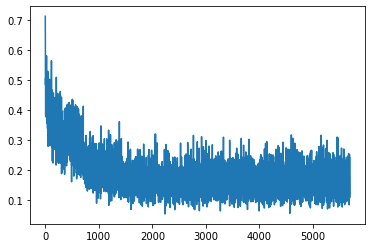

In [154]:
plt.plot(history["train_bce"])

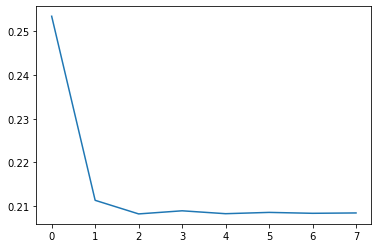

In [155]:
plt.plot(history["val_bce"])

We now save the model as well as the optimizer to file. We can then use the model in our testing notebook.

In [156]:
torch.save(net.state_dict(), "a-train-efficientnet-b7-deep-image-classifier-checkpoint.pth")

In [158]:
torch.save(optimizer.state_dict(), "optimizer-a-train-efficientnet-b7-deep-image-classifier-checkpoint.pth")

## Fune tune efficientnet

Now that we have transfer learned the last few layers, if needed we can train the entire network. Training the entire network with weights initialized near the optimal will make convergence easier.

In [ ]:
if tracking_active:
    import wandb
    wandb.init(
        name='efficientnet-finetune-runv1',
        project="deepfake-detection",
        notes="Finetune and train entire network after transfer learning on deepfake images.",
    )

In [ ]:
net.load_state_dict(torch.load('efficientnet-b7-deep-image-classifier-checkpoint.pth', map_location=gpu))

In [ ]:
_ = net.eval()

In [ ]:
## Train full network
epochs = 1
lr = 1e-4
wandb.config.update({"epochs": epochs, "lr": lr}, allow_val_change=True)

In [ ]:
evaluate(net, val_loader, device=gpu)

In [ ]:
## Training
wd = 0.1

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [50]:
wandb.watch(net)

In [ ]:
fit(1)

## References

### Binary Classification Demo
1. [Kaggle Kernel for Training a Binary Classifier for deepfake detection](https://www.kaggle.com/humananalog/binary-image-classifier-training-demo)